In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [8]:

from filterflow.smc import SMC
from filterflow.base import State, Observation, InputsBase, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler
from filterflow.observation.base import ObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

# Define State Space Model

## Specify linear dynamic

In [4]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5
observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [5]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [9]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_transition_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

## State Space

In [10]:
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)

In [11]:
initial_particle = tf.constant(np.random.random(2), dtype = tf.float32)

In [12]:
states, observations = ss_model(initial_particle, T)

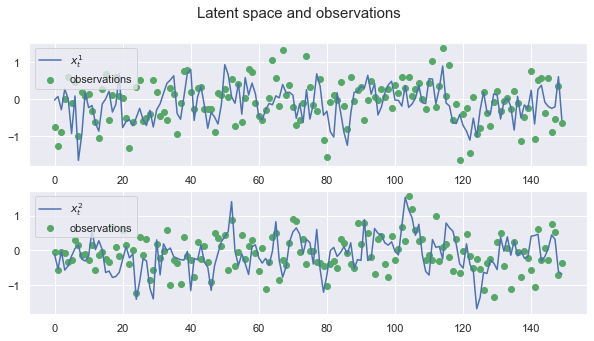

In [14]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])


linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

## Specify Particle Filter Components

In [15]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

In [16]:
proposal_model = BootstrapProposalModel(transition_model)

In [17]:
resampling_criterion = AlwaysResample()
resampling_method = MultinomialResampler()

In [18]:
particle_filter = SMC(observation_model, 
                                 transition_model, proposal_model, resampling_criterion, resampling_method)

In [19]:
import time

In [20]:

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)

In [21]:
record_states = particle_filter(initial_state, observations)

In [23]:
# compute states
computed_states = []
for t, observation in enumerate(observations):
    state = record_states.read(t)
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

## Plot

In [24]:
import numpy as np
import bqplot.pyplot as bplt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'y'}}
fig = bplt.figure(animation_duration=0)
lines = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=np_obs[:,0], 
                colors=['red'], 
                axes_options=axes_options)

if False:
    true_state_ln = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=np_states[:,0], 
                colors=['blue'], 
                axes_options=axes_options)

computed_lin = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=computed_states, 
                colors=['green'], 
                axes_options=axes_options)

scatt = bplt.scatter([], [], colors=['blue'], axes_options=axes_options)


max_y = np.max([np_obs[:,0]])
min_y = np.min([computed_states, np_obs[:,0]])

bplt.set_lim(min_y-0.5, max_y+0.5, 'y')
bplt.set_lim(0, len(np_obs), 'x')

fig

Figure(axes=[Axis(label='t', scale=LinearScale(max=150.0, min=0.0)), Axis(label='y', orientation='vertical', s…

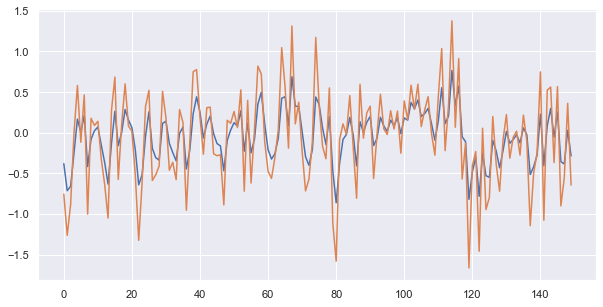

In [25]:
plt.figure(figsize=(10,5))
plt.plot(computed_states)
plt.plot(np_obs[:,0])

In [ ]:
jitter = np.random.normal(0., 0.25, n_particles)

gif_dir = './gif_dir'
os.mkdir(gif_dir)
for t in range(observation_series.size()):
    state = record_states.read(t)
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[0,:,0]
    weights = np.exp(log_weights)
    x = t + jitter
    y = particles
    
    plt.plot(np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                     ghmm_output.observations[:,0], 'rx')

    computed_lin = plt.plot(np.linspace(0, t, t), 
                            computed_states[:t], 'g')
    plt.ylim(-2.,2.)
    plt.plot(x, y, 'bx')
    plt.savefig(os.path.join(gif_dir,'plot_{0}.png'.format(t)))
    plt.clf()
    

In [ ]:
fps = [os.path.join('./gif_dir', 'plot_{0}.png'.format(t)) for t in range(T+1)]

frames = [Image.open(fn) for fn in fps]

frames[0].save('pf.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

## Likelihood

In [ ]:
final_state = record_states.read(150)

In [ ]:
final_state.log_likelihoods